In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Introduction tot data assimilation
## Practical session Day 2 : Tangent and adjoint models

### D2.2 Tangent model and parameter estimation (SIR epidemiologic model)

We consider the following ODE system (SIR model) that models the spread of an epidemics in a population:
\begin{array}{lr}
S'(t)=-\tau S(t)I(t),& \\
I'(t)=\tau S(t)I(t)-\nu I(t)&\\
R'(t)=\nu I(t),&t\in[0,T],\\
\end{array}

together with the initial condition: $S(t=0)=N-I0, I(t=0)=I_0, R(t=0)=0$.\\

In this exercise we  fix the time interval $[0,T] = [0,250]$, and the following values: $N=6e7, I_0=1$. The values of $y$ are computed on every integer point in this interval (observations available every day).


- Compute the derivatives wrt the parameters $\tau, \nu$. 
    - Implement a function Dy that takes as input $\tau, \nu$ and as output the Jacobian matrix of $y$ wrt these 2 parameters. Check the validity of this function using finite differences.
	
- Fix some values $\theta^*=(\tau^*, \nu^*)$ close to $(3.10^{-9}, 10^{-1})$ up to a factor of e.g. 10. Compute the solution $y(\theta^*)=(S,I,R)$ and add gaussian noise to $I$ to generate the observations. (Note: here the observation operator $L$ consists of measuring the quantity $I(t)$).
- Implement the Gauss-Newton algorithm to estimate the parameters with an initial guess that is not close from $\theta^*$.

In [7]:
parameters = {'tau':3e-9, 'nu':1e-2}
N0 = 6e7
I0 = 1

In [8]:
def SIR(t,y,tau,nu):
    s = y[0]
    i = y[1]
    r = y[2]
    yprime = [-tau*s*i, tau*s*i-nu*i, nu*i]
    return yprime

def SIRDSIR(t,Y,tau,nu):  
    # d1 : derivative wrt tau ; d2 : derivative wrt nu
    s = Y[0]
    i = Y[1]
    r = Y[2]
    d1s = Y[3]
    d1i = Y[4]
    d1r = Y[5]
    d2s = Y[6]
    d2i = Y[7]
    d2r = Y[8]
    dts = -tau*s*i
    dti = tau*s*i-nu*i
    dtr = nu*i
    dtd1s = -s*i -tau*d1s*i -tau*s*d1i
    dtd1i = s*i + tau*d1s*i + tau*s*d1i-nu*d1i
    dtd1r = nu*d1i
    dtd2s = -tau*d2s*i -tau*s*d2i
    dtd2i = -i + tau*d2s*i + tau*s*d2i-nu*d2i
    dtd2r = i + nu*d2i

    return np.array([dts,dti,dtr,dtd1s,dtd1i,dtd1r,dtd2s,dtd2i,dtd2r])


def yDy(tau,nu):
    # solve the ODE and the 3 tangent models
    sol = solve_ivp(SIRDSIR,[0,T],[N0-I0,I0,0,0,0,0,0,0,0],t_eval=timepoints,args=(tau,nu),rtol = 1e-6)
    return sol.y

In [9]:
T = 250
numpoints = 300
timepoints = np.linspace(0,T,numpoints)

tau0 = parameters['tau']
nu0 = parameters['nu']
Y = yDy(tau0, nu0)
Yr = np.reshape(Y[:3,:],3*numpoints)
Jacobian = np.zeros((3*numpoints,2))
Jacobian[:,0] = np.reshape(Y[3:6,:],3*numpoints)
Jacobian[:,1] = np.reshape(Y[6:9,:],3*numpoints)


#%%########## check for the derivatives
h = 1e-9*np.random.randn(2)
for epsilon in [1e-2, 1e-4, 1e-6, 1e-8, 1e-10, 1e-12]:    
    Yh = yDy(tau0+epsilon*h[0], nu0+epsilon*h[1])
    Yhr = np.reshape(Yh[:3,:],3*numpoints)
    difdiv = 1/epsilon * (Yhr-Yr)
    product_jac = np.dot(Jacobian,h)
    reldifference = np.linalg.norm(difdiv-product_jac)/np.linalg.norm(difdiv)
    print(epsilon,reldifference)

#%%############# parameters estimation
tautrue = parameters['tau']
nutrue = parameters['nu']


Ytrue = yDy(tautrue, nutrue)
noiselevel = 5e4
Iobs = Ytrue[1,:] + noiselevel*np.random.randn(numpoints)

0.01 0.002775644878972691
0.0001 2.822177755434447e-05
1e-06 4.781282131973087e-06
1e-08 3.8043970485328074e-05
1e-10 0.0015041757732504458
1e-12 0.0036970705788990717


0 [4.56236501e-09 1.46556668e-02]
1 [3.94340452e-09 8.66095415e-03]
2 [3.39617414e-09 9.28624445e-03]
3 [3.04259342e-09 9.88297526e-03]
4 [2.99948207e-09 1.00003346e-02]
5 [2.99980756e-09 9.99971790e-03]
6 [2.99980750e-09 9.99971816e-03]
7 [2.99980750e-09 9.99971816e-03]
8 [2.99980750e-09 9.99971816e-03]
9 [2.99980750e-09 9.99971816e-03]
10 [2.99980750e-09 9.99971816e-03]
11 [2.99980750e-09 9.99971816e-03]
12 [2.99980750e-09 9.99971816e-03]
13 [2.99980750e-09 9.99971816e-03]
14 [2.99980750e-09 9.99971816e-03]
15 [2.99980750e-09 9.99971816e-03]
16 [2.99980750e-09 9.99971816e-03]
17 [2.99980750e-09 9.99971816e-03]
18 [2.99980750e-09 9.99971816e-03]
19 [2.99980750e-09 9.99971816e-03]


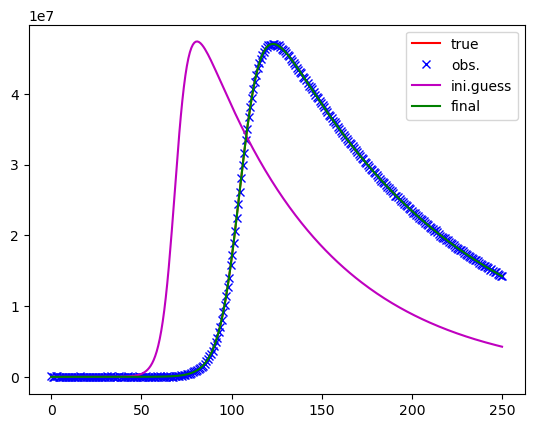

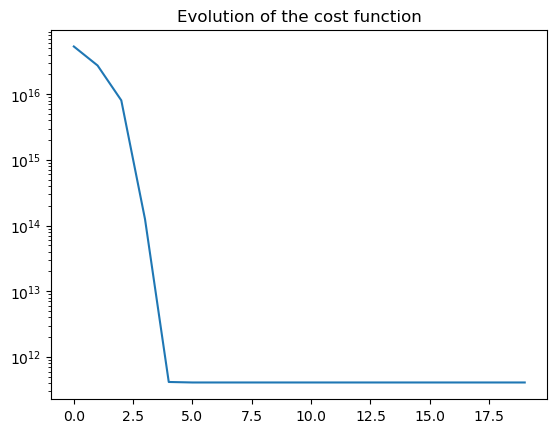

In [10]:
fig, ax = plt.subplots()
ax.plot(timepoints,Ytrue[1,:],'r',label='true')
ax.plot(timepoints,Iobs,'bx',label='obs.')

precision = 0.8

tauini = tautrue*(1-precision+2*precision*np.random.rand())
nuini = nutrue*(1-precision+2*precision*np.random.rand())

paramk = np.array([tauini, nuini])
nbit = 20
Jlist = []

for it in range(nbit):
    print(it, paramk)
    Y = yDy(paramk[0], paramk[1])
    Ik = Y[1,:]
    if it==0:
        ax.plot(timepoints,Ik,'m',label='ini.guess')
    F = Ik - Iobs
    Jlist.append(0.5*np.linalg.norm(Ik-Iobs)**2)
    DF = np.zeros((numpoints,2))
    DF[:,0] = np.reshape(Y[4,:],numpoints)
    DF[:,1] = np.reshape(Y[7,:],numpoints)

    DFTF = np.dot(DF.transpose(),F)
    DFTDF = np.dot(DF.transpose(),DF)
    dk = np.linalg.solve(DFTDF, -DFTF)
    paramk = paramk + 1*dk
    
ax.plot(timepoints,Ik,'g',label='final')
ax.legend()

fig, ax = plt.subplots()
ax.semilogy(Jlist)
ax.set_title('Evolution of the cost function');

We consider the  logistic model:
$$
\begin{array}{lr}
y'(t)=\alpha y(t)(1-y(t)/K),& t\in[0,T]\\
y(t=0)=y_0,& t=0.
\end{array}$$

for some given constants $\alpha>0$ and $K>0$. The initial population is $y_0>0$.
In this exercise we  fix the time interval $[0,T] = [0,200]$. The values of $y$ are computed on 1000 points equally spaced in this interval (option $t\_eval$ of $t\_solve\_{ivp}$. The parameters are $\theta=(\alpha,K)$.

We consider observations of the population
$$y_{obs}(t_i)=y(\theta^*)(t_i)+n,$$
where $n$ is the realization of gaussian random noise with variance $\sigma^2$, and $\theta^*$ is the (true) value of the parameters.
The following cost function is to be minimized:
$$j(\theta)=\dfrac{1}{2}\sum_i (y(\theta)(t_i)-y_{obs}(t_i))^2.$$


- Calculate the gradient of $j$ using the adjoint method.
	
- Compute the adjoint state. Note: since it is a backwards ODE the solution using {\tt solve\_ivp} has to be carefully written (indicate the integration bounds $[T,0]$ in this order).
	
 Make a numerical check of the validity of the gradient thus obtained.
	
	


In [11]:
T = 200

parameters = {'alpha':0.1, 'K':1e4}

In [12]:
def adjlogistic(t,p,alpha,K,ydirect):
    # the evolution of the adjoint state outside the location
    # of dirac source terms
    jm = np.max(np.where(timepoints<=t))
    ydirectt = ydirect[jm]
    return -alpha*p + 2*alpha*ydirectt*p/K

def solvey(params,y0):
    # solve the ODE with constant alpha
    sol = solve_ivp(logistic,[0,T],[y0],t_eval=timepoints,args=(params['alpha'],params['K']),rtol = 1e-12,atol=1e-8)
    return sol.y.T

def solveadj(params,ydirect,source):
    # solves the adjoint problem
    #   ydirect is the sol of the direct pb, 
    #   source are the dirac source terms in a nsource x 2 array: (ti,yiobs)
    p = np.zeros(numpoints)
    timep = np.zeros(numpoints)
    plt.figure()
    nsource = np.shape(source)[0]
    ilist = np.zeros(nsource+2) # list of time subintervals
    ilist[1:nobs+1] = source[:,0]
    ilist[0] = 0
    ilist[nobs+1] = numpoints-1
    yobslist = np.zeros(nsource+2) 
    yobslist[1:nobs+1] = source[:,1]
    pk = 0
    for k in range(nobs+1,0,-1):
        tk = timepoints[int(ilist[k])]
        tkm = timepoints[int(ilist[k-1])]
        indk = np.logical_and(timepoints>=tkm,timepoints<=tk)
        timepointsk = timepoints[indk]
        sol = solve_ivp(adjlogistic,[tk,tkm],[pk],t_eval=timepointsk[::-1],args=(params['alpha'],params['K'],ydirect),rtol=1e-12,atol=1e-8)
        plt.plot(sol.t,sol.y[0,:])
        pk = sol.y[0,-1] - (ydirect[int(ilist[k-1])][0]-yobslist[k-1])
        p[indk[::-1]] = sol.y[0,:]
        timep[indk[::-1]] = sol.t
    return p, timep

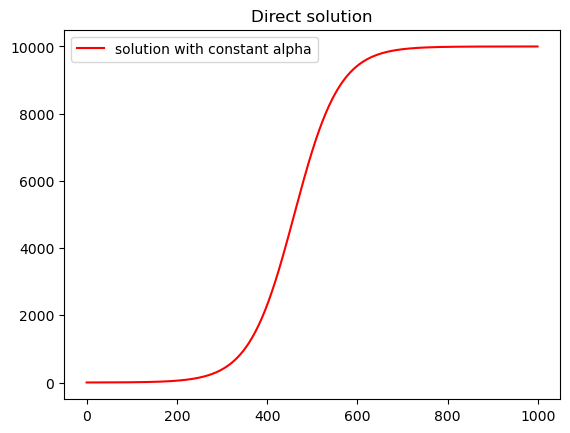

In [14]:
numpoints = 1000
timepoints = np.linspace(0,T,numpoints)

Y = solvey(parameters, 1.0)

fig, ax = plt.subplots()
ax.plot(Y,'r',label='solution with constant alpha')
ax.legend()
ax.set_title('Direct solution');

/var/folders/j7/_p_15hz14vg0xfymsqfnwlcm0000gn/T/ipykernel_88828/2849065695.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  obs[k,1] = Ytrue[int(iobs[k])]


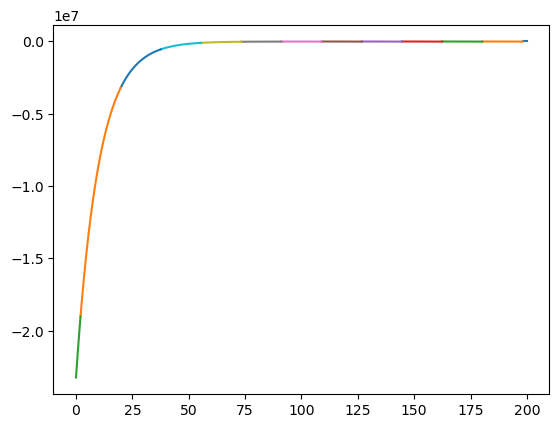

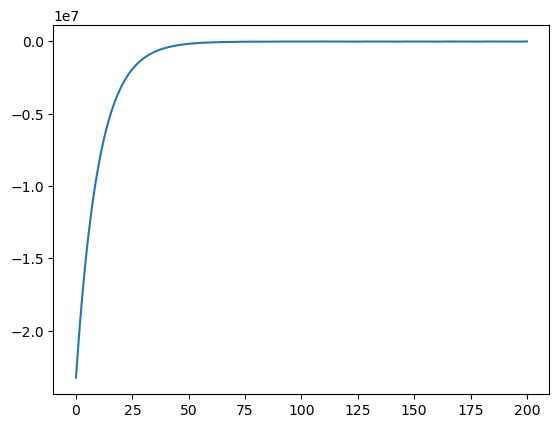

In [15]:
nobs = 12
iobs = np.floor(np.linspace(10,numpoints-10,nobs)) # index of observation times
obs = np.zeros((nobs,2))
obs[:,0] = iobs
Ytrue = solvey({'alpha':0.08,'K':2e3}, 1.0)
for k in range(nobs):
    obs[k,1] = Ytrue[int(iobs[k])]

# the cost function is j = sum_i (y(iobs)-obs[i])**2
p, tp = solveadj(parameters,Y,obs)

plt.figure()
plt.plot(tp,p);

0.01 0.1712201771500172
0.0001 -0.011471220406038945
1e-06 -0.012888467756995833
1e-08 -0.012902602323689834
1e-10 -0.012902784739039806
1e-12 -0.01291201880799799


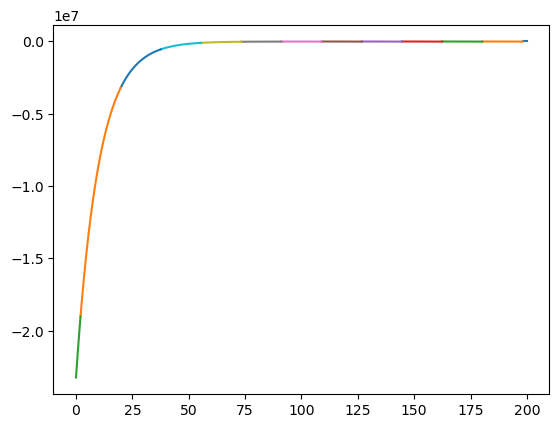

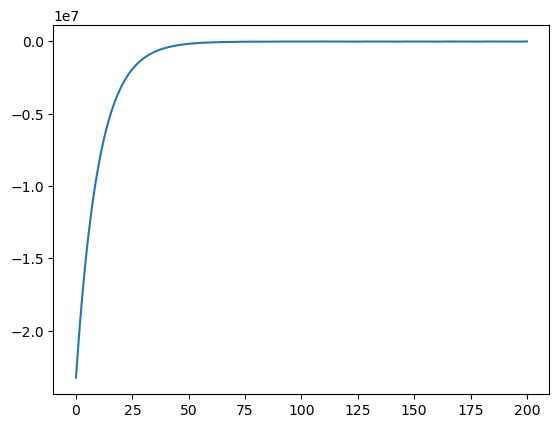

In [16]:
# the cost function is j = sum_i (y(iobs)-obs[i])**2
p, tp = solveadj(parameters,Y,obs)

plt.figure()
plt.plot(tp,p)
# caution: the adjoint p is the array of the values in the reverse order !
padj = p[::-1]

# computation of the gradient of j using the adjoint
# component along K
deltat = T/(numpoints-1)

gradjK = -deltat * np.sum(parameters['alpha']*Y[:,0]**2/parameters['K']**2*padj)
gradjalpha = -deltat*np.sum(Y[:,0]*(1-Y[:,0]/parameters['K'])*padj)
gradj = np.array([gradjalpha,gradjK])

# check the gradient :
# comparison of j(params+epsilon h) and j(params)+epsilon*(h,gradj)

j = 0.5*np.sum((Y[iobs.astype(int),0]-obs[:,1])**2)

h = np.random.randn(2)

for epsilon in [1e-2,1e-4,1e-6,1e-8,1e-10,1e-12]:
    parametersh = {'alpha':0.1+h[0]*epsilon, 'K':1e4+h[1]*epsilon}
    Yh = solvey(parametersh, 1.0)
    jh = 0.5*np.sum((Yh[iobs.astype(int),0]-obs[:,1])**2)
    difdiv = (jh-j)/epsilon
    res2 = np.vdot(h,gradj)
    print(epsilon,(difdiv-res2)/res2)